In [76]:
# Cell 0: Installations
#%pip install scikit-learn scikit-image
#%pip install SimpleITK
%pip install nibabel nilearn scipy scikit-image

  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached certifi-2024.8.30-py3-none-any.whl.metadata (2.2 kB)
   ---------------------------------------- 0.0/10.4 MB ? eta -:--:--
   ---------------------------------------- 10.4/10.4 MB 59.0 MB/s eta 0:00:00
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
   ---------------------------------------- 0.0/3.8 MB ? eta -:--:--
   ---------------------------------------- 3.8/3.8 MB 56.4 MB/s eta 0:00:00
Using cached certifi-2024.8.30-py3-none-any.whl (167 kB)
Note: you may need to restart the kernel to use updated packages.


In [36]:
# Cell 1: Import necessary libraries
import os
import pandas as pd

In [37]:
# Cell 2: Define the base directory and categories
# Assuming the notebook and Images folder are in the same directory
base_dir = 'Images'
categories = ['PPMI_Images_PD', 'PPMI_Images_SWEDD', 'PPMI_Images_Cont']

In [38]:
# Cell 3: Collect DICOM file paths for each category
data = []

for category in categories:
    category_path = os.path.join(base_dir, category)
    for patient_id in os.listdir(category_path):
        patient_path = os.path.join(category_path, patient_id)
        reconstructed_path = os.path.join(patient_path, 'Reconstructed_DaTSCAN')
        if os.path.exists(reconstructed_path):
            for exam_date in os.listdir(reconstructed_path):
                exam_date_path = os.path.join(reconstructed_path, exam_date)
                for exam_id in os.listdir(exam_date_path):
                    exam_id_path = os.path.join(exam_date_path, exam_id)
                    for root, dirs, files in os.walk(exam_id_path):
                        for file in files:
                            if file.endswith('.dcm'):
                                file_path = os.path.join(root, file)
                                data.append({
                                    'category': category,
                                    'patient_id': patient_id,
                                    'file_path': file_path
                                })


In [39]:
# Cell 4: Create a DataFrame to organize the data
df = pd.DataFrame(data)
df['label'] = df['category'].map({
    'PPMI_Images_PD': 'PD',
    'PPMI_Images_SWEDD': 'SWEDD',
    'PPMI_Images_Cont': 'Control'
})
df = df[['patient_id', 'file_path', 'label']]
df.head()


,patient_id,file_path,label
0,100001,Images\PPMI_Images_PD\100001\Reconstructed_DaT...,PD
1,100001,Images\PPMI_Images_PD\100001\Reconstructed_DaT...,PD
2,100001,Images\PPMI_Images_PD\100001\Reconstructed_DaT...,PD
3,100001,Images\PPMI_Images_PD\100001\Reconstructed_DaT...,PD
4,100001,Images\PPMI_Images_PD\100001\Reconstructed_DaT...,PD


In [40]:
# Cell 5: Summary statistics
print('Number of images per category:')
print(df['label'].value_counts())


Number of images per category:
label
PD         3364
Control     378
SWEDD       137
Name: count, dtype: int64


In [41]:
# Cell 6: Save DataFrame to CSV (optional)
df.to_csv('dicom_file_paths.csv', index=False)


In [42]:
# Cell 7: Import additional libraries for image processing
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bars


In [43]:
# Cell 8: Function to load and preprocess DICOM images
def load_dicom_image(file_path, target_shape=None):
    """
    Load a DICOM file and return the image data as a NumPy array.
    Optionally resizes the image to the target_shape.
    """
    ds = pydicom.dcmread(file_path)
    img = ds.pixel_array.astype(np.float32)
    
    # Apply rescale slope and intercept if present
    if 'RescaleSlope' in ds:
        img *= float(ds.RescaleSlope)
    if 'RescaleIntercept' in ds:
        img += float(ds.RescaleIntercept)
    
    # Normalize the image intensities
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    
    # Resize image if target_shape is specified
    if target_shape and img.shape != target_shape:
        from skimage.transform import resize
        img = resize(img, target_shape, mode='reflect', anti_aliasing=True)
    
    return img


In [44]:
# Cell 9: Initialize dictionaries to store sums and counts for each group
mean_sums = {'PD': None, 'SWEDD': None, 'Control': None}
counts = {'PD': 0, 'SWEDD': 0, 'Control': 0}
shapes = {'PD': None, 'SWEDD': None, 'Control': None}


In [45]:
# Cell 10: Compute mean images for each group
# We'll iterate over the DataFrame 'df' created earlier

# Map labels to group names
group_labels = {'PD': 'PD', 'SWEDD': 'SWEDD', 'Control': 'Control'}

# Iterate over each group
for label in group_labels.values():
    group_df = df[df['label'] == label]
    print(f"Processing group: {label}")
    
    # Initialize progress bar
    for idx, row in tqdm(group_df.iterrows(), total=group_df.shape[0]):
        file_path = row['file_path']
        try:
            # Load the image
            if counts[label] == 0:
                # For the first image, get the shape
                img = load_dicom_image(file_path)
                shapes[label] = img.shape
                mean_sums[label] = np.zeros(shapes[label], dtype=np.float32)
            else:
                # For subsequent images, resize if necessary
                img = load_dicom_image(file_path, target_shape=shapes[label])
            
            # Accumulate the sum
            mean_sums[label] += img
            counts[label] += 1
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue
    
    # Compute the mean
    mean_sums[label] /= counts[label]


Processing group: PD


100%|██████████| 3364/3364 [00:58<00:00, 57.64it/s]


Processing group: SWEDD


100%|██████████| 137/137 [00:01<00:00, 87.88it/s]


Processing group: Control


100%|██████████| 378/378 [00:06<00:00, 62.18it/s]


In [64]:
# Cell 11 (Updated): Visualize the mean images for each group with corrected orientation
import numpy as np
import matplotlib.pyplot as plt

def plot_mean_views(mean_img, title_prefix):
    """
    Plots the axial, coronal, and sagittal views of the mean image with corrected orientation.
    Each image is rotated counterclockwise by 90 degrees.
    """
    # Swap axes if necessary to match anatomical planes
    # This rearranges the data from (Z, Y, X) to (X, Y, Z)
    mean_img = np.swapaxes(mean_img, 0, 2)

    # Compute the middle slices
    axial_slice = mean_img[:, :, mean_img.shape[2] // 2]
    coronal_slice = mean_img[:, mean_img.shape[1] // 2, :]
    sagittal_slice = mean_img[mean_img.shape[0] // 2, :, :]

    # Adjust the orientation of slices
    # First, flip slices to correct the orientation
    axial_slice = np.flipud(axial_slice)
    coronal_slice = np.flipud(coronal_slice)
    sagittal_slice = np.flipud(sagittal_slice)

    # Then, rotate each slice counterclockwise by 90 degrees
    axial_slice = np.rot90(axial_slice, k=1)
    coronal_slice = np.rot90(coronal_slice, k=1)
    sagittal_slice = np.rot90(sagittal_slice, k=1)

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    plt.suptitle(f"{title_prefix} Mean Views")

    axes[0].imshow(axial_slice, cmap='gray', origin='upper')
    axes[0].set_title('Axial View')
    axes[0].axis('off')

    axes[1].imshow(coronal_slice, cmap='gray', origin='upper')
    axes[1].set_title('Coronal View')
    axes[1].axis('off')

    axes[2].imshow(sagittal_slice, cmap='gray', origin='upper')
    axes[2].set_title('Sagittal View')
    axes[2].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


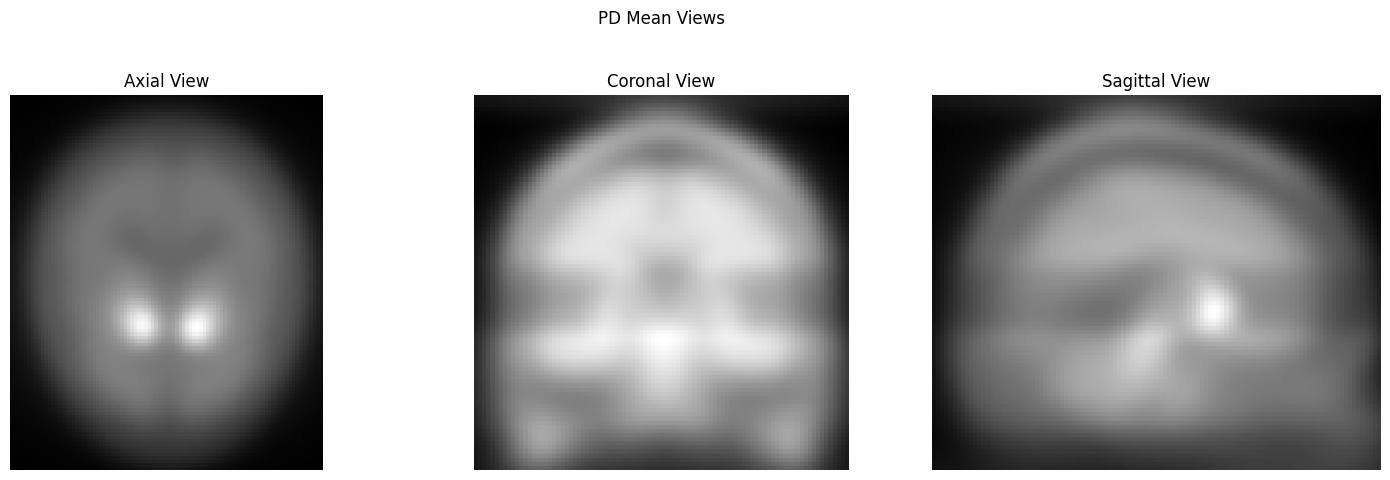

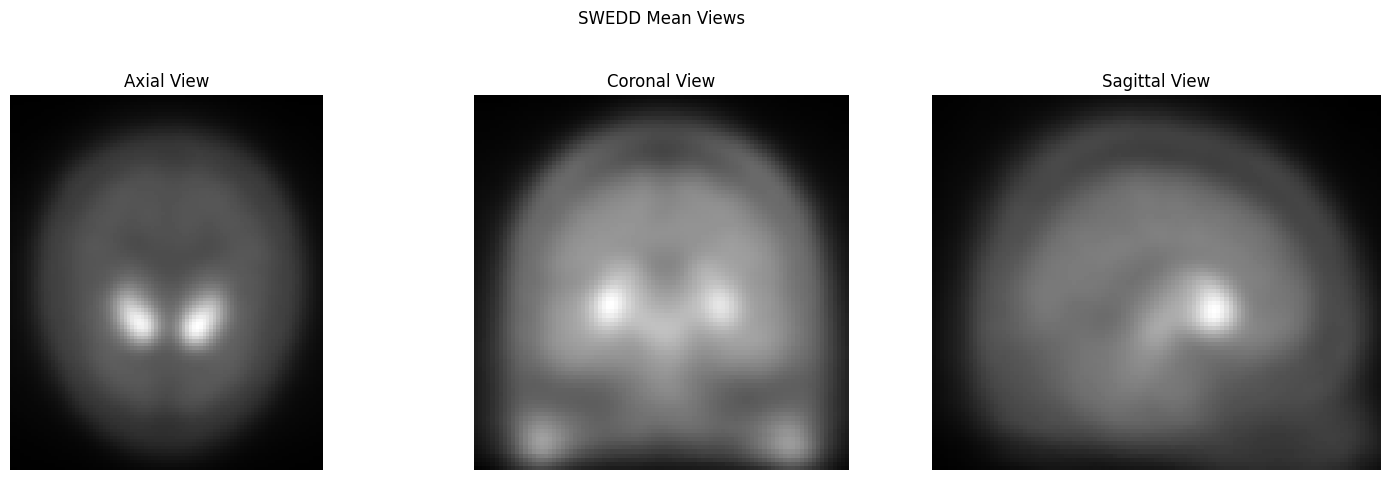

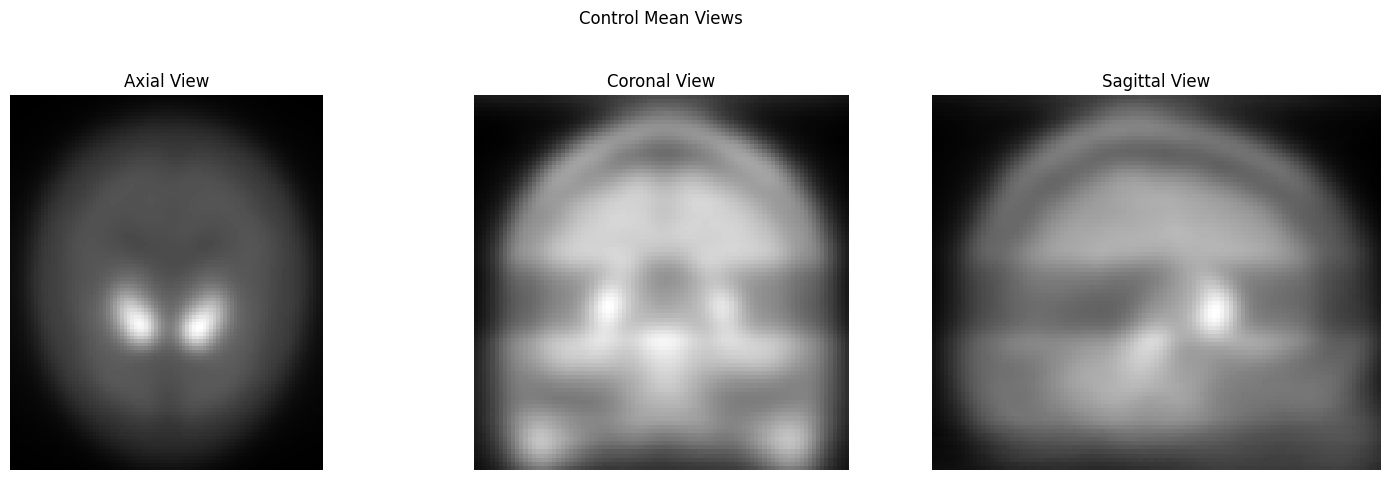

In [65]:
# Cell 12: Plot the mean views for each group
for label in group_labels.values():
    mean_img = mean_sums[label]
    plot_mean_views(mean_img, title_prefix=label)


In [74]:
# Cell 13: Select and visualize a random patient from each group

import random

# Function to select a random patient from each group
def select_random_patients(df, groups):
    random_patients = {}
    for group in groups:
        group_df = df[df['label'] == group]
        unique_patients = group_df['patient_id'].unique()
        if len(unique_patients) == 0:
            print(f"No patients found in group: {group}")
            continue
        selected_patient = random.choice(unique_patients)
        random_patients[group] = selected_patient
    return random_patients

# Define the groups
groups = ['PD', 'SWEDD', 'Control']

# Select random patients
random_patients = select_random_patients(df, groups)
print("Selected Random Patients:")
for group, patient in random_patients.items():
    print(f"{group}: Patient ID {patient}")

Selected Random Patients:
PD: Patient ID 71809
SWEDD: Patient ID 3315
Control: Patient ID 113050


Visualizing Patient ID 71809 - File: Images\PPMI_Images_PD\71809\Reconstructed_DaTSCAN\2021-11-02_15_16_03.0\I1619846\PPMI_71809_NM_Reconstructed_DaTSCAN_Br_20220912134959680_1_S1092623_I1619846.dcm


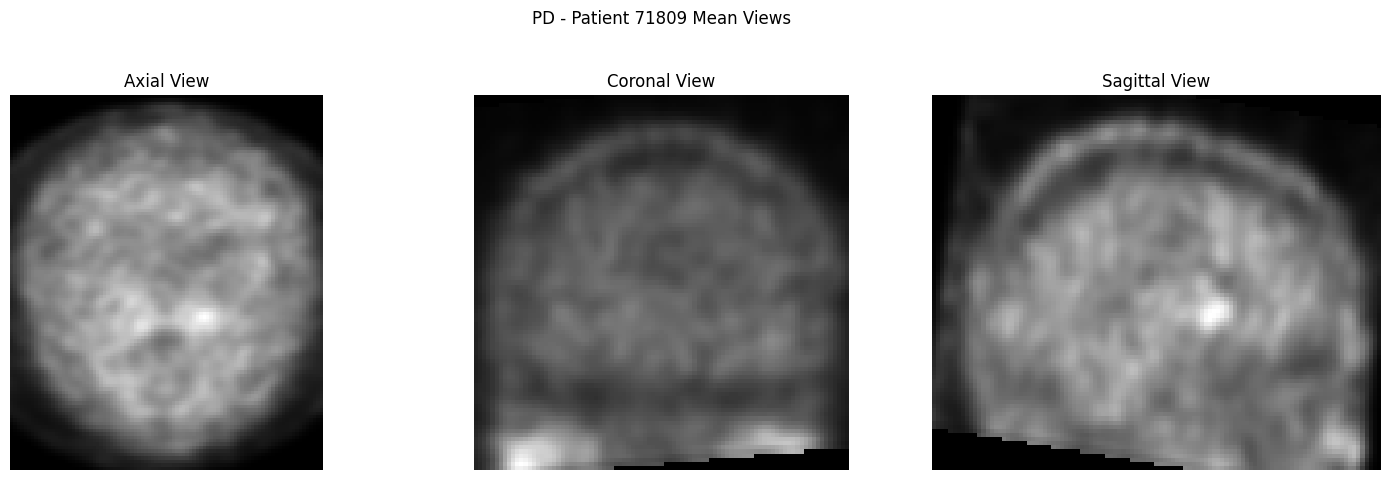

Visualizing Patient ID 3315 - File: Images\PPMI_Images_SWEDD\3315\Reconstructed_DaTSCAN\2012-02-14_16_11_02.0\I341235\PPMI_3315_NM_Reconstructed_DaTSCAN_Br_20121019115539953_1_S142206_I341235.dcm


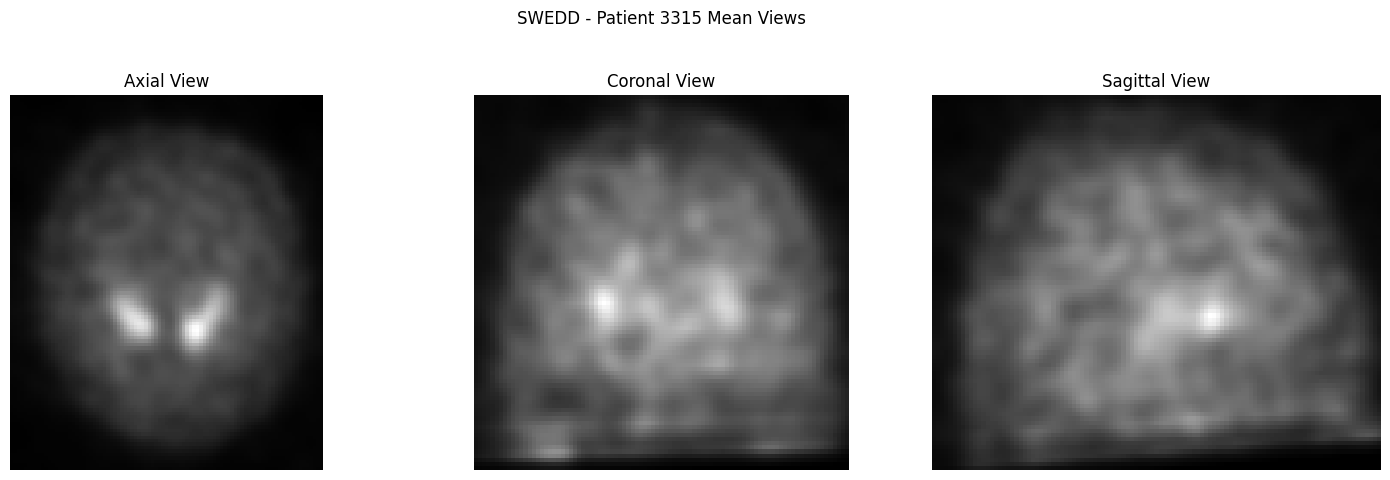

Visualizing Patient ID 113050 - File: Images\PPMI_Images_Cont\113050\Reconstructed_DaTSCAN\2021-10-08_12_33_39.0\I1526825\PPMI_113050_NM_Reconstructed_DaTSCAN_Br_20211214182238247_1_S1090562_I1526825.dcm


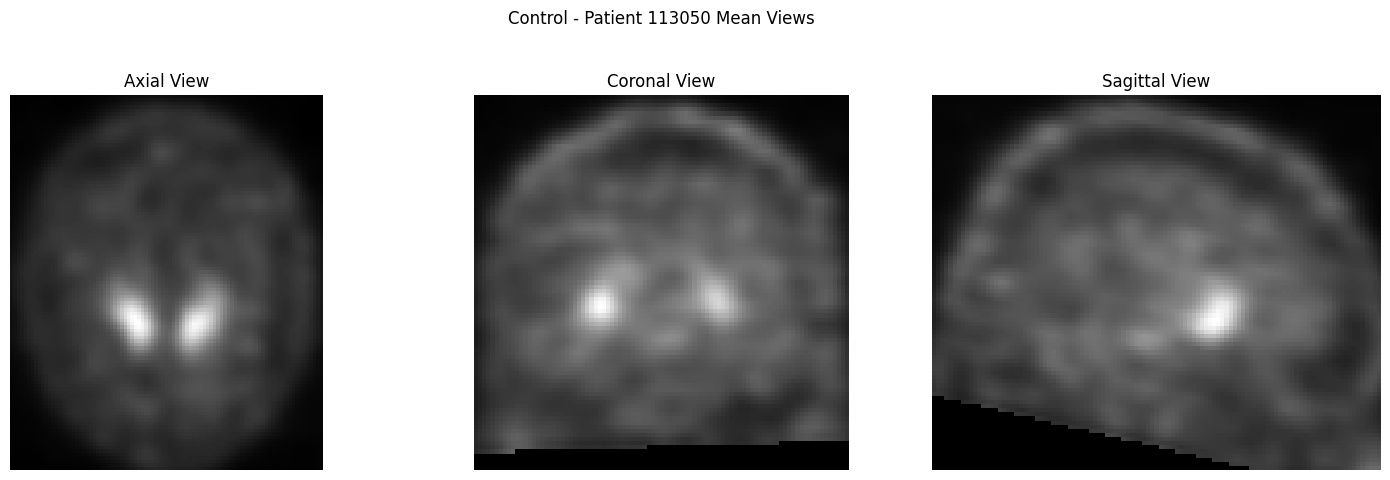

In [75]:
# Function to visualize a random image for a given patient
def visualize_random_patient(df, patient_id, label):
    """
    Select a random DICOM file for the given patient and plot its views.
    """
    patient_df = df[(df['patient_id'] == patient_id) & (df['label'] == label)]
    if patient_df.empty:
        print(f"No images found for Patient ID {patient_id} in group {label}.")
        return
    
    # Select a random image
    random_file = random.choice(patient_df['file_path'].tolist())
    print(f"Visualizing Patient ID {patient_id} - File: {random_file}")
    
    # Load the image
    img = load_dicom_image(random_file)
    
    # Plot the views
    plot_mean_views(img, title_prefix=f"{label} - Patient {patient_id}")

# Iterate over each group and visualize a random patient
for group, patient_id in random_patients.items():
    visualize_random_patient(df, patient_id, group)
